In [1]:
%matplotlib inline
import struct
import numpy as np
import numpy.linalg as LA
from array import array
import matplotlib.pyplot as plt

## Read in training data

In [2]:
def load_mnist(
    dataset="training", selecteddigits=range(10), 
    path='/Users/hwlin/Documents/Machine_Learning/Assignments/Assignment3/'
    ):

    #Check training/testing specification. Must be "training" (default) or "testing"
    if dataset == "training":
        fname_digits = path + '/' + 'train-images.idx3-ubyte'
        fname_labels = path + '/' + 'train-labels.idx1-ubyte'
    elif dataset == "testing":
        fname_digits = path + '/' + 't10k-images.idx3-ubyte'
        fname_labels = path + '/' + 't10k-labels.idx1-ubyte'
    else:
        raise ValueError("dataset must be 'testing' or 'training'")
        
        
    #Import digits data
    digitsfileobject = open(fname_digits, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", digitsfileobject.read(16))
    digitsdata = array("B", digitsfileobject.read())
    digitsfileobject.close()

    #Import label data
    labelsfileobject = open(fname_labels, 'rb')
    magic_nr, size = struct.unpack(">II", labelsfileobject.read(8))
    labelsdata=array("B",labelsfileobject.read())
    labelsfileobject.close()
    
    #Find indices of selected digits
    indices=[k for k in range(size) if labelsdata[k] in selecteddigits]
    N=len(indices)
    
    #Create empty arrays for X and T
    X = np.zeros((N, rows*cols), dtype=np.uint8)
    T = np.zeros((N), dtype=np.uint8)
    
    #Fill X from digitsdata
    #Fill T from labelsdata
    for i in range(N):
        X[i] = digitsdata[indices[i]*rows*cols:(indices[i]+1)*rows*cols]
        T[i] = labelsdata[indices[i]]
    
    return X,T

In [3]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [4]:
X, T = load_mnist(dataset="training",selecteddigits=[2, 4])

## Excel I/O

In [5]:
directory = "/Users/hwlin/Documents/Machine_Learning/Assignments/"
excelfile = directory + "Assignment3/Assignment_3_Submission_Template.xlsx"


def readExcelSheet1(excelfile):
    from pandas import read_excel
    return (read_excel(excelfile)).values


def readExcelRange(excelfile,sheetname="Sheet1",startrow=1,endrow=1,startcol=1,endcol=1):
    from pandas import read_excel
    values=(read_excel(excelfile, sheetname,header=None)).values;
    return values[startrow-1:endrow,startcol-1:endcol]


def readExcel(excelfile,**args):
    if args:
        data=readExcelRange(excelfile,**args)
    else:
        data=readExcelSheet1(excelfile)
    if data.shape==(1,1):
        return data[0,0]
    elif (data.shape)[0]==1:
        return data[0]
    else:
        return data
    
    
def writeExcelData(x,excelfile,sheetname,startrow,startcol):
    from pandas import DataFrame, ExcelWriter
    from openpyxl import load_workbook
    df=DataFrame(x)
    book = load_workbook(excelfile)
    writer = ExcelWriter(excelfile, engine='openpyxl') 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name=sheetname,startrow=startrow-1, startcol=startcol-1, header=False, index=False)
    writer.save()
    writer.close()
    
    
def getSheetNames(excelfile):
    from pandas import ExcelFile
    return (ExcelFile(excelfile)).sheet_names

## Classifier function

In [6]:
def Build2DHistogramClassifier(X, T, B, digit_p):
    Hp = np.zeros([B,B]).astype('int32')
    Hn = np.zeros([B,B]).astype('int32')
    p1max = np.amax(X[:,0])
    p1min = np.amin(X[:,0])
    p2max = np.amax(X[:,1])
    p2min = np.amin(X[:,1])
    for i in range(len(T)):
        r = (np.round(((B-1)*(X[i,0]-p1min)/(p1max - p1min)))).astype('int32')
        c = (np.round(((B-1)*(X[i,1]-p2min)/(p2max - p2min)))).astype('int32')
        if T[i] == digit_p:
            Hp[r,c]+=1
        else:
            Hn[r,c]+=1
    return Hp, Hn, p1max, p1min, p2max, p2min

In [7]:
def HistProb(queries, X, Hp, Hn):
    num_queries = np.size(queries, 0)
    probp = np.zeros(num_queries, dtype='float')
    probn = np.zeros(num_queries, dtype='float')
    p1max = np.amax(X[:,0])
    p1min = np.amin(X[:,0])
    p2max = np.amax(X[:,1])
    p2min = np.amin(X[:,1])
    
    r = (np.round(((B-1)*(queries[0]-p1min)/(p1max - p1min)))).astype('int32')
    c = (np.round(((B-1)*(queries[1]-p2min)/(p2max - p2min)))).astype('int32')
    probp = Hp[r, c]/(Hp[r, c] + Hn[r, c])
    probn = Hn[r, c]/(Hn[r, c] + Hp[r, c])
    
    if probp > probn:
        label = 4
    elif probp < probn:
        label = 2
    else:
        label = 0
    return label, probp, probn

In [8]:
def BayesPDF(queries, X):
    mu = np.mean(X, axis=0)
    cov = np.cov(X.T)
    part1 = 1 / (((2 * np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)))
    part2 = (-1/2) * ((queries-mu).T.dot(np.linalg.inv(cov))).dot((queries-mu))
    pdf = part1 * np.exp(part2)
    return pdf

In [9]:
def BayesProb(queries, X, T):
    pdf_p = BayesPDF(queries, X[T == 4])
    pdf_n = BayesPDF(queries, X[T == 2])
    nump = len(T[T == 4])
    numn = len(T[T == 2])
    probp = pdf_p * nump/ (pdf_p * nump + pdf_n * numn)
    probn = pdf_n * numn / (pdf_p * nump + pdf_n * numn)
    
    if probp > probn:
        label = 4
    elif probp < probn:
        label = 2
    else:
        label = 0
    return label, probp, probn

## XZCVPR

In [10]:
def doPCA(X, mu, ncomponent):
    Z = X - mu
    C = np.cov(Z,rowvar=False)
    [lam,V]=np.linalg.eigh(C)
    lam=np.flipud(lam);V=np.flipud(V.T)
    P = np.dot(Z,V.T)
    
    Preduced = P[:,0:ncomponent]
    R = np.dot(P[:,0:ncomponent],V[0:ncomponent,:])
    Xrec = R + mu
    
    return Z, Preduced, R, Xrec

## Principle components

In [11]:
# whole training set
mu = np.mean(X, axis=0) # fill in
Z = X-mu
C =np.cov(Z,rowvar=False)
[lam,V]=np.linalg.eigh(C)
lam=np.flipud(lam);V=np.flipud(V.T)
v1 = V[0,:] 
v2 = V[1,:]
V = V[:2]  #### from lecture: reduce the dimension here
writeExcelData([mu],excelfile,'Results',2,2)
writeExcelData([v1],excelfile,'Results',3,2)
writeExcelData([v2],excelfile,'Results',4,2)
print("Written mu, v1, v2")

Np = X[T==4].shape[0]
Nn = X[T==2].shape[0]
print('Np = ', Np)
print('Nn = ', Nn)
writeExcelData([Np,Nn],excelfile,'Results',6,2)
print("Written Np, Nn")

P =np.dot(Z,V.T)
PP = P[T==4]
PN = P[T==2]

mup = np.mean(PP[:,0:2], axis=0)
mun = np.mean(PN[:,0:2], axis=0)
print('mup = ', mup)
print('mun = ', mun)
writeExcelData([mup,mun],excelfile,'Results',9,2)
print("Written mup, mun")

cp = np.cov(np.transpose(PP[:,0:2]))
cn = np.cov(np.transpose(PN[:,0:2]))
print('cp = ', cp)
print('cn = ', cn)
writeExcelData(cp,excelfile,'Results',12,2)
writeExcelData(cn,excelfile,'Results',14,2)
print("Written cp, cn")

Written mu, v1, v2
('Np = ', 5842)
('Nn = ', 5958)
Written Np, Nn
('mup = ', array([-604.46616583,   42.74194865]))
('mun = ', array([ 592.69743887,  -41.90977912]))
Written mup, mun
('cp = ', array([[  55497.67494819,   25720.99969703],
       [  25720.99969703,  183506.50507563]]))
('cn = ', array([[ 153522.61081452,   24961.14722594],
       [  24961.14722594,  353737.08744414]]))
Written cp, cn


## 2D scatter plot

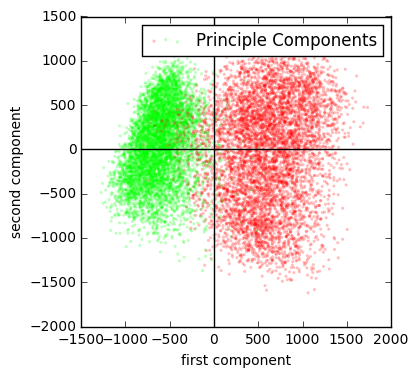

In [20]:
labeln = 2
labelp = 4

T_vec = T.reshape((len(T),))  #reshape T as vector

# For best effect, points should not be drawn in sequence but in random order
np.random.seed(0)
randomorder = np.random.permutation(np.arange(len(T_vec)))

# Set color
cols = np.zeros((len(T_vec),4)) # Initialize matrix to hold colors
cols[T_vec==labeln] = [1, 0, 0, 0.25] # N = red, opacity = 0.25
cols[T_vec==labelp] = [0, 1, 0, 0.25] # P = green, opacity = 0.25

# Draw scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(P[randomorder, 0], P[randomorder, 1], s=5, linewidth=0, facecolors=cols[randomorder,:], marker='o',
          label='Principle Components')
ax.set_aspect('equal')
ax.legend()

plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.xlabel('first component')
plt.ylabel('second component')

plt.show()

## Build histogram classifier

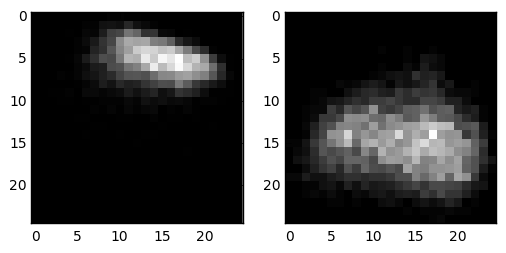

Written p1min, p1max, p2min, p2max
Written Hp, Hn


In [15]:
# Bins
B = 25

# Histogram
digit_p = 4
Hp, Hn, p1max, p1min, p2max, p2min = Build2DHistogramClassifier(P[:,0:2], T, B, digit_p)

# Check up
plt.subplot(1,2,1)
plt.imshow(Hp, interpolation='None',cmap=plt.get_cmap('gray'))
plt.subplot(1,2,2)
plt.imshow(Hn, interpolation='None',cmap=plt.get_cmap('gray'))
plt.show()

writeExcelData([[p1min,p1max]],excelfile,'Results',17,2)
writeExcelData([[p2min,p2max]],excelfile,'Results',18,2)
print("Written p1min, p1max, p2min, p2max")

writeExcelData(Hp,excelfile,'Results',20,2)
writeExcelData(Hn,excelfile,'Results',46,2)
print("Written Hp, Hn")

## Apply the classifier to Xp and Xn

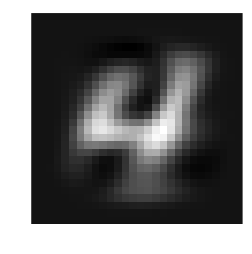

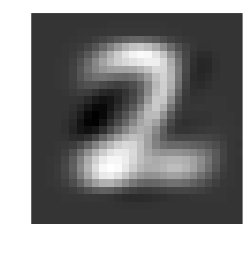

Written xp, zp, rp, pp, xrecp
Written xn, zn, rn, pn, xrecn


In [16]:
idx_p = 489 #4  
xp = X[idx_p,:]
zp = xp - mu
pp = P[idx_p,0:2]
rp = np.dot(pp,V[0:2,:])
xrecp = rp + mu   

idx_n = 4600 #2
xn = X[idx_n,:]
zn = xn - mu
pn = P[idx_n,0:2]
rn = np.dot(pn,V[0:2,:])
xrecn = rn + mu   

plt.close('all')
plt.subplot(1,2,1)
vectortoimg(xrecp)
plt.subplot(1,2,2)
vectortoimg(xrecn)
plt.show()

writeExcelData([xp],excelfile,'Results',74,2)
writeExcelData([zp],excelfile,'Results',75,2)
writeExcelData([pp],excelfile,'Results',76,2)
writeExcelData([rp],excelfile,'Results',77,2)
writeExcelData([xrecp],excelfile,'Results',78,2)
print("Written xp, zp, rp, pp, xrecp")

writeExcelData([xn],excelfile,'Results',80,2)
writeExcelData([zn],excelfile,'Results',81,2)
writeExcelData([pn],excelfile,'Results',82,2)
writeExcelData([rn],excelfile,'Results',83,2)
writeExcelData([xrecn],excelfile,'Results',84,2)
print("Written xn, zn, rn, pn, xrecn")

In [17]:
# Apply the classifier
# Positive
# Histogram
truthp = 4
resultlabelHp, resultprobHp, resultprobHn = HistProb(pp, P[:,0:2], Hp, Hn)

# Bayesian
pdf = BayesPDF(pp, P[:,0:2])
resultlabelBp, resultprobBp, resultprobBn = BayesProb(pp, P[:,0:2], T)

writeExcelData([truthp],excelfile,'Results',88,2)
writeExcelData([resultlabelHp],excelfile,'Results',89,2)
writeExcelData([resultprobHp],excelfile,'Results',89,3)
writeExcelData([resultlabelBp],excelfile,'Results',90,2)
writeExcelData([resultprobBp],excelfile,'Results',90,3)
print("Written truthp, resultlabelHp, resultprobHp, resultlabelBp, resultprobBp")


# Negative
# Histogram
truthn = 2
resultlabelHn, resultprobHp, resultprobHn = HistProb(pn, P[:,0:2], Hp, Hn)

# Bayesian
pdf = BayesPDF(pn, P[:,0:2])
resultlabelBn, resultprobBp, resultprobBn = BayesProb(pn, P[:,0:2], T)

writeExcelData([truthn],excelfile,'Results',92,2)
writeExcelData([resultlabelHn],excelfile,'Results',93,2)
writeExcelData([resultprobHn],excelfile,'Results',93,3)
writeExcelData([resultlabelBn],excelfile,'Results',94,2)
writeExcelData([resultprobBn],excelfile,'Results',94,3)
print("Written truthn, resultlabelHn, resultprobHn, resultlabelBn, resultprobBn")

Written truthp, resultlabelHp, resultprobHp, resultlabelBp, resultprobBp
Written truthn, resultlabelHn, resultprobHn, resultlabelBn, resultprobBn


In [18]:
# Apply classifier through whole training set for accuracy
AccuracyArrayH = np.zeros([len(T),]).astype('int32')
AccuracyArrayB = np.zeros([len(T),]).astype('int32')

for i in range(len(T)):
    PP = P[i,0:2]
    
    resultlabelH, resultprobHp, resultprobHn = HistProb(PP, P[:,0:2], Hp, Hn)
    resultlabelB, resultprobBp, resultprobBn = BayesProb(PP, P[:,0:2], T)
    
    if resultlabelH == T[i]:
        AccuracyArrayH[i] = 1
        
    if resultlabelB == T[i]:
        AccuracyArrayB[i] = 1
        
accuracyH = np.sum(AccuracyArrayH) / len(T)
accuracyB = np.sum(AccuracyArrayB) / len(T)

#writeExcelData([accuracyH,accuracyB],excelfile,'Results',97,2)
#print("Written accuracyH, accuracyB")

In [19]:
print np.sum(AccuracyArrayH)
print np.sum(AccuracyArrayB)
print len(T)

7975
11363
11800


## Sci-kit Learn shortcut

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)
print Y_sklearn.max()
print Y_sklearn.min()